# GP Regression on Noisy Sinusoidal Data

Original tutorial: [Gaussian Process Regression in TensorFlow Probability](https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP)

Translated to `PYMC3` using: 
- Tutorial [Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html)
- Example [Latent variable implementation](https://docs.pymc.io/notebooks/GP-Latent.html)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

In [2]:
import warnings

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

## Create Sinusoidal data with Numpy

In [3]:
def sinusoid(x):
    return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
    """
      Generate noisy sinusoidal observations at a random set of points.

      Returns:
         observation_index_points, observations
    """
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
    # y = f(x) + noise
    observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
    return index_points_, observations_

In [4]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [5]:
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

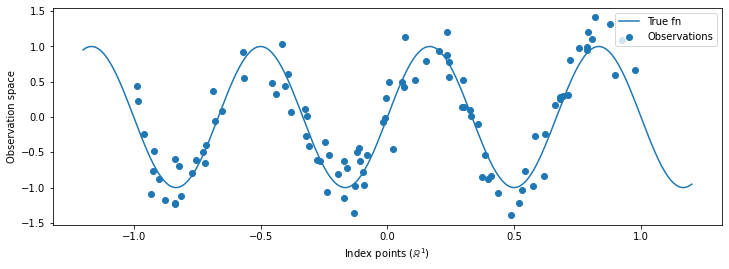

In [6]:
# Plot the true function and observations.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Coding the model in PyMC3
- Docs [Continuous distributions](https://docs.pymc.io/api/distributions/continuous.html)
- Docs [Inference](https://docs.pymc.io/api/inference.html) contains functions for MCMC sampling - `pymc3.sampling.sample(...)`
- Docs [Implementations](https://docs.pymc.io/api/gp/implementations.html)
- Docs [Covariance Functions](https://docs.pymc.io/api/gp/cov.html)
- Example notebook [Mean and Covariance Functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html)

In [7]:
with pm.Model() as model:
    ls = pm.Lognormal("lengthscale", mu=0., sigma=1.0) # 0.1
    amplitude = pm.Lognormal("amplitude", mu=0., sigma=1.0) # 1.0
    # Specify the covariance function.
    cov = amplitude**2 * pm.gp.cov.ExpQuad(1, ls=ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=observation_index_points_)
    
    sigma = pm.Lognormal("sigma", mu=0., sigma=1.)
    y_ = pm.Normal("y", mu=f, sigma=sigma, observed=observations_)
    
    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, f_rotated_, amplitude, lengthscale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 184 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [9]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(trace)[["lengthscale", "amplitude", "f_rotated_"]].to_array() > 1.03).values
)
print(f"{n_nonconverged} variables MCMC chains appear not to have converged.")

0 variables MCMC chains appear not to have converged.


### Use conditional distribution

In [10]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", predictive_index_points_)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])

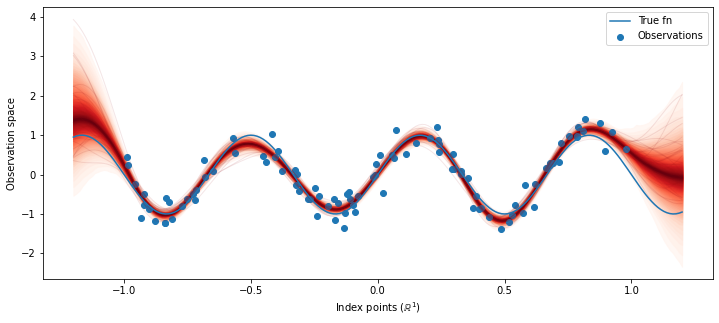

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], predictive_index_points_)

# plot the data and the true latent function
ax.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
ax.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

#### Tensorflow probability vs. PyMC3
The Exponentiated Quadratic kernel. Also refered to as the Squared Exponential, or Radial Basis Function kernel.

`tfp` `k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))`
```python
tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude=None, length_scale=None, feature_ndims=1, validate_args=False,
    name='ExponentiatedQuadratic'
)
```
while `pymc3` 
$$k(x,x')=\exp[-\frac{(x-x')^2}{2l^2}]$$
```python
pymc3.gp.cov.ExpQuad(input_dim, ls=None, ls_inv=None, active_dims=None)
```


